In [1]:
from matplotlib.colors import ListedColormap
from types import SimpleNamespace
from pathlib import Path
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import pandas as pd
import json
import os

# vars
path_workdir = Path("/home/b05b01002/HDD/project_nanoprep_re")
path_input = path_workdir / "outputs/BUSCO"
path_output = Path("./output")
os.makedirs(path_output, exist_ok=True)

# BUSCO summary file name template
path_busco_summary = lambda wildcards: \
    path_input / f"{wildcards.software}/{wildcards.beta_or_backend}/{wildcards.name}_{wildcards.accuracy}/run_{wildcards.lineage_data}/short_summary.json"

# wildcards
names = [
    "egr-109-bio1",
    "egr-109-bio2",
    "lch-109-bio1",
    "lch-109-bio2",
    "ptr-109-bio1",
    "ptr-109-bio2",
    "ptr-111-bio1",
    "ont-10x-human",
    "ont-visium-mouse",
    "mouse-retina-subset1",
    "mouse-retina-subset2"
]
accuracies = [
    "sup",
    "hac",
    "fast",
    "pre-called"
]
betas = [f"beta{i}" for i in ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0", "1.5", "2.0"]]
backends = ["phmm", "edlib"]
softwares = ["pychopper", "nanoprep"]
lineage_datasets = {
    "egr-109-bio1": "eudicotyledons_odb12",
    "egr-109-bio2": "eudicotyledons_odb12",
    "lch-109-bio1": "embryophyta_odb12",
    "lch-109-bio2": "embryophyta_odb12",
    "ptr-109-bio1": "malpighiales_odb12",
    "ptr-109-bio2": "malpighiales_odb12",
    "ptr-111-bio1": "malpighiales_odb12",
    "ont-10x-human": "primates_odb12",
    "ont-visium-mouse": "rodentia_odb12",
    "mouse-retina-subset1": "rodentia_odb12",
    "mouse-retina-subset2": "rodentia_odb12"
}

In [2]:
busco_results = []
for software, beta_or_backends in zip(softwares, [backends, betas]):
    for beta_or_backend in beta_or_backends:
        for name in names:
            if name in ["mouse-retina-subset1", "mouse-retina-subset2"]:
                accuracies_tmp = accuracies[3:]
            else:
                accuracies_tmp = accuracies[:3]
            lineage_data = lineage_datasets[name]
            for accuracy in accuracies_tmp:
                wildcards = SimpleNamespace(software=software, beta_or_backend=beta_or_backend, name=name, accuracy=accuracy, lineage_data=lineage_data)
                fpath = path_busco_summary(wildcards)
                if not fpath.is_file():
                    continue
                with open(fpath) as handle_in:
                    data = json.load(handle_in)
                    results = data["results"]
                    results["software"] = software
                    results["beta_or_backend"] = beta_or_backend
                    results["name"] = name
                    results["accuracy"] = accuracy
                    busco_results.append(results)

In [3]:
df = pd.DataFrame(busco_results)
df.head()

,one_line_summary,Complete percentage,Complete BUSCOs,Single copy percentage,Single copy BUSCOs,Multi copy percentage,Multi copy BUSCOs,Fragmented percentage,Fragmented BUSCOs,Missing percentage,Missing BUSCOs,n_markers,domain,software,beta_or_backend,name,accuracy
0,"C:3.3%[S:3.2%,D:0.1%],F:1.0%,M:95.7%,n:2805",3.3,93,3.2,90,0.1,3,1.0,27,95.7,2685,2805,eukaryota,pychopper,phmm,egr-109-bio1,sup
1,"C:2.1%[S:2.0%,D:0.0%],F:1.1%,M:96.8%,n:2805",2.1,58,2.0,57,0.0,1,1.1,31,96.8,2716,2805,eukaryota,pychopper,phmm,egr-109-bio1,hac
2,"C:1.7%[S:1.7%,D:0.0%],F:0.8%,M:97.5%,n:2805",1.7,49,1.7,49,0.0,0,0.8,22,97.5,2734,2805,eukaryota,pychopper,phmm,egr-109-bio1,fast
3,"C:3.9%[S:3.6%,D:0.2%],F:0.9%,M:95.3%,n:2805",3.9,109,3.6,102,0.2,7,0.9,24,95.3,2672,2805,eukaryota,pychopper,phmm,egr-109-bio2,sup
4,"C:2.8%[S:2.6%,D:0.1%],F:0.9%,M:96.4%,n:2805",2.8,78,2.6,74,0.1,4,0.9,24,96.4,2703,2805,eukaryota,pychopper,phmm,egr-109-bio2,hac


In [4]:
long_df = pd.DataFrame()
for i in ["Single copy percentage", "Multi copy percentage", "Fragmented percentage"]:
    df_tmp = df.loc[:, [i, "software", "beta_or_backend", "name", "accuracy"]]
    df_tmp = df_tmp.rename(columns={i: "percentage"})
    df_tmp["category"] = i
    long_df = pd.concat([long_df, df_tmp])

long_df

,percentage,software,beta_or_backend,name,accuracy,category
0,3.2,pychopper,phmm,egr-109-bio1,sup,Single copy percentage
1,2.0,pychopper,phmm,egr-109-bio1,hac,Single copy percentage
2,1.7,pychopper,phmm,egr-109-bio1,fast,Single copy percentage
3,3.6,pychopper,phmm,egr-109-bio2,sup,Single copy percentage
4,2.6,pychopper,phmm,egr-109-bio2,hac,Single copy percentage
...,...,...,...,...,...,...
397,1.8,nanoprep,beta2.0,ont-visium-mouse,sup,Fragmented percentage
398,1.9,nanoprep,beta2.0,ont-visium-mouse,hac,Fragmented percentage
399,1.3,nanoprep,beta2.0,ont-visium-mouse,fast,Fragmented percentage
400,0.2,nanoprep,beta2.0,mouse-retina-subset1,pre-called,Fragmented percentage


In [5]:
long_df.loc[long_df["accuracy"] == "pre-called", "accuracy"] = "sup"

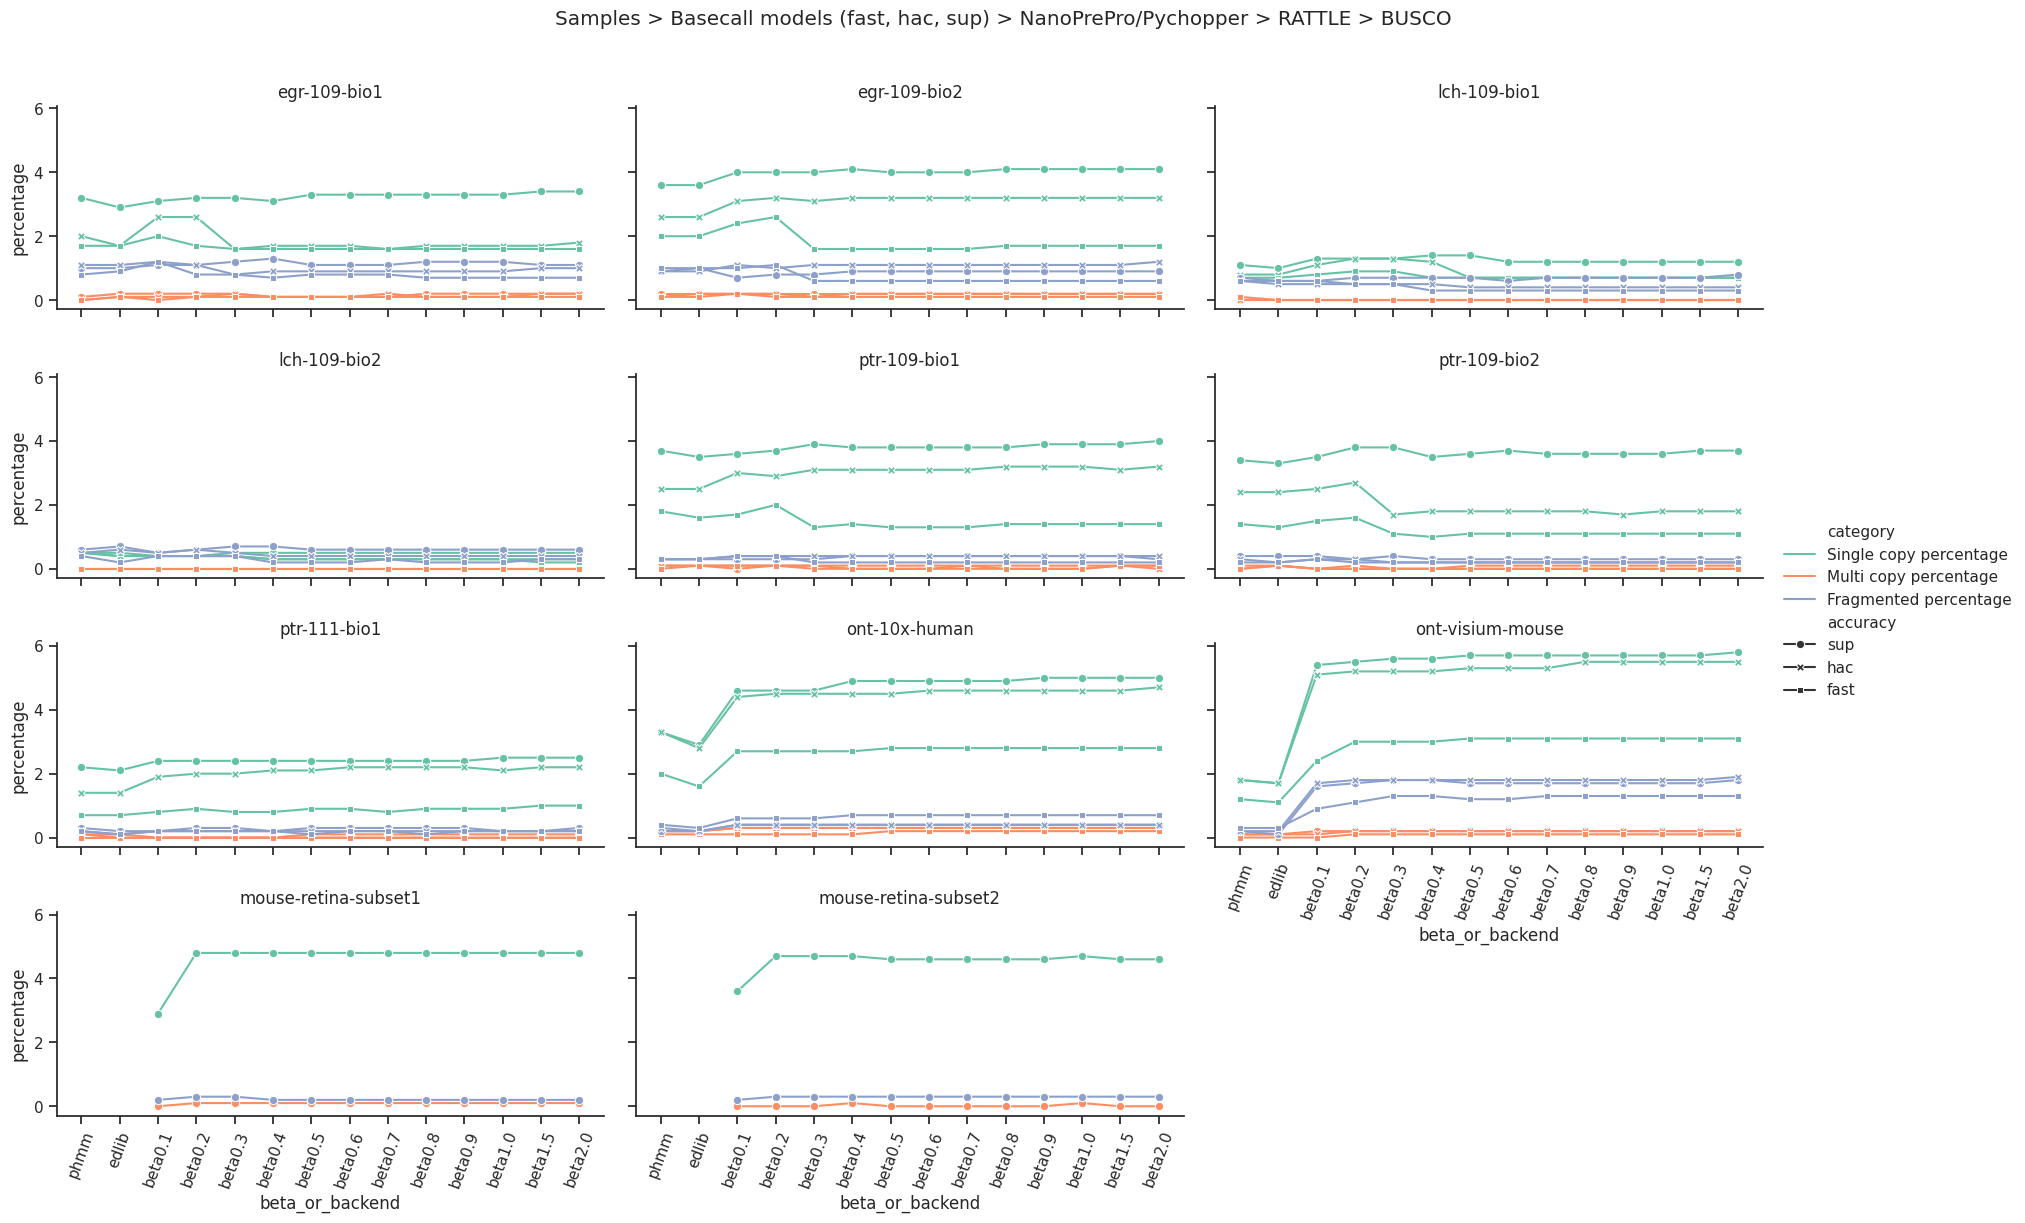

In [6]:
sns.set_theme(style="ticks")
g = sns.FacetGrid(long_df, col="name", col_wrap=3, aspect=2)
g.map_dataframe(
    sns.lineplot,
    x="beta_or_backend",
    y="percentage",
    hue="category",
    style="accuracy",
    palette="Set2",
    markers=True,
    dashes=False,
)
g.add_legend()
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Samples > Basecall models (fast, hac, sup) > NanoPrePro/Pychopper > RATTLE > BUSCO")
g.tick_params(axis="x", rotation=70)
g.savefig(path_output / "BUSCOs.svg")


/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/b05b01002/Installed/miniconda3/envs/python-dev/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximat

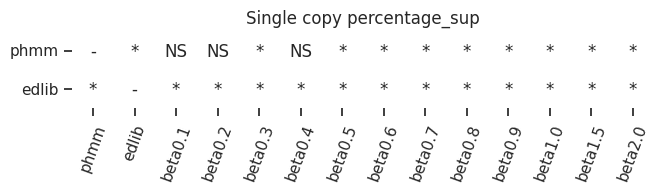

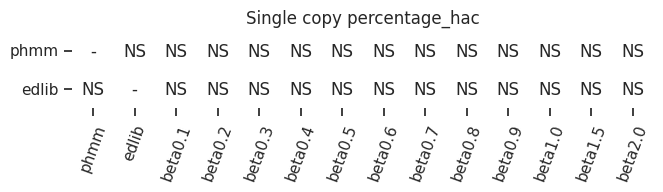

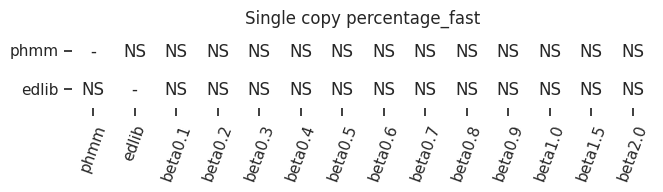

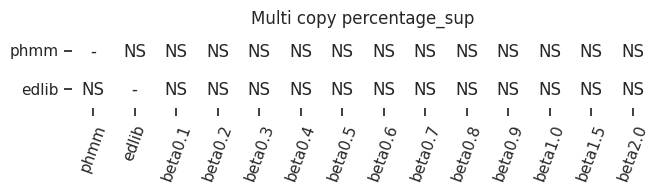

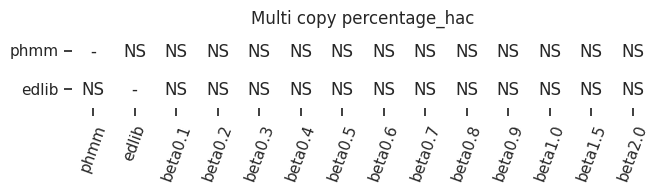

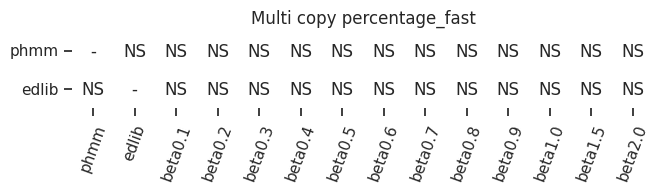

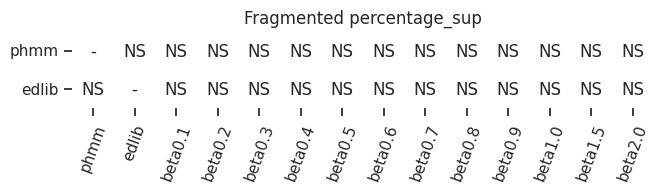

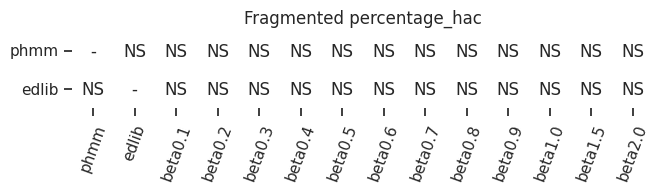

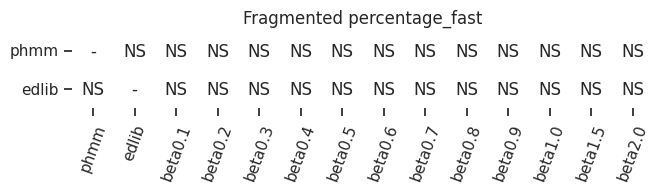

In [7]:
for busco_category in ["Single copy percentage", "Multi copy percentage", "Fragmented percentage"]:
    for accuracy in ["sup", "hac", "fast"]:
        not_pcs114 = ~df["name"].isin(["mouse-retina-subset1", "mouse-retina-subset2"])
        is_accuracy = df["accuracy"] == accuracy
        res = sp.posthoc_wilcoxon(
            df[not_pcs114 & is_accuracy],
            val_col=busco_category,
            group_col="beta_or_backend",
            zero_method="zsplit",
            p_adjust="fdr_bh"
        )
        out = sp.sign_table(res.loc[["phmm", "edlib"], :])
        fig, ax = plt.subplots(1,1,figsize=(7.5, 1))
        ax = sns.heatmap(
            data=res.loc[["phmm", "edlib"]],
            annot=out,
            fmt="s",
            cmap=ListedColormap("white"),
            cbar=False
        )
        # ax.xaxis.tick_top()
        ax.tick_params(axis="x", rotation=70)
        ax.set_title(f"{busco_category}_{accuracy}")
        plt.savefig(f"output/wilcoxon_signed_rank_{busco_category}_{accuracy}.svg", bbox_inches="tight")
        res.loc[["phmm", "edlib"]].to_csv(f"output/wilcoxon_signed_rank_{busco_category}_{accuracy}.csv")